# Movie Studio Analysis

<img src="images/banner.png/" style="height:400px">

# Business Understanding

Our company has decided to create a **new movie studio**. This is a new venture for the company and our first introduction to the film industry. I will be exploring what types of films are currently doing the best at the box office. 

In order to help decide what types of films to create, I investigate the following 3 business questions:
1. What **genre** movie would produce the most profits?
2. What **director** would produce the most profits?
3. Which **release month** would produce the most profits?

# Data Understanding

I will be using 3 datasets in this notebook.
1. **bom.movie_gross.csv.gz**: This is a dataset from [BoxOfficeMojo](https://www.BoxOfficeMojo.com) containing domestic and foreign gross of 3,387 movies. I use this dataset to analyze total gross of movies.
2. **tn.movie_budgets.csv.gz**: This is a datset from [The Numbers](https://www.the-numbers.com/) containing release date, production budget, domestic gross and worldwide gross for 5,782 movies. I use this dataset to determine the most profitable movies and to analyze the release month of the movies.
3. **im.db**: This is a database from [IMDB](https://www.IMDB.com) containing 8 tables. I chose 3 tables to use - movie_basics, directors, and persons.  `movie_basics` has basic movie information for 146,144 movies. `directors` has 140,417 entries of movie id's matched to person id's. `persons` has 606648 people related to the movies with their birth year, death year, and primary professions. I use this dataset to determine the director and genre that will result in the most profitable movie.
##DELETE **rt.reviews.tsv.gz**: This is a dataset from [Rotten Tomatoes](https://www.RottenTomatoes.com) containing ratings and additional movie information for 1,560 movies. I use this dataset to determine the movie rating that will result in the most profitable movie.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.mode.copy_on_write = True

In [2]:
# Save Box Office Mojo dataset to bom_df
bom_df = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')

In [3]:
# Save The Numbers dataset to budget_df
budget_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

In [4]:
# Save IMDB dataset to conn
conn = sqlite3.connect('data/zippedData/im.db')

# Save movie_basics table as a Pandas dataframe movie_basics_df
query_movie_basics = """

SELECT *
  FROM movie_basics
"""

movie_basics_df = pd.read_sql(query_movie_basics, conn)

# Save directors table as a Pandas dataframe directors_df
query_directors = """

  SELECT *
    FROM directors
GROUP BY movie_id
"""

directors_df = pd.read_sql(query_directors, conn)


movie_basics_df = pd.read_sql(query_movie_basics, conn)

# Save persons table as a Pandas dataframe persons_df
query_persons = """

SELECT *
  FROM persons
"""

persons_df = pd.read_sql(query_persons, conn)

In [63]:
## DELETE
# Save Rotten Tomatoes dataset to rt_movie_info_df
rt_movie_info_df = pd.read_csv('data/zippedData/rt.movie_info.tsv.gz', sep='\t', encoding='windows-1252')

## Data Preparation

I take a closer look at each dataset in this section. 

### Box Office Mojo

In [6]:
# Preview first 5 entries of bom_df
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


I take a look at the columns, number of nulls, and data types. I notice `foreign_gross` is type object. I will have to convert this data to floats when clearning. 

In [7]:
# View the overall shape, dtypes and null counts for each column in bom_df
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### The Numbers

In [8]:
# Preview first 5 entries of budget_df
budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [9]:
# View the overall shape, dtypes and null counts for each column in bom_df
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


There are no nulls in this dataset. I will be creating a profit column to indicate the difference between `production_budget` and `worldwide_gross`. I also will create a separate column for month of release in order to determine the most profitable release month.

### IMDB

In [10]:
# Preview first 5 entries of movie_basics_df
movie_basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [11]:
# Check for duplicates in movie_basics_df
movie_basics_df[movie_basics_df.duplicated(subset='movie_id')]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres


In [12]:
# View the overall shape, dtypes and null counts for each column in movie_basics_df
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [13]:
# Preview what is listed under the null genre entries
movie_basics_df[movie_basics_df['genres'].isna()]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,NaN,None
22,tt0253093,Gangavataran,Gangavataran,2018,134.0,None
35,tt0306058,Second Coming,Second Coming,2012,95.0,None
40,tt0326592,The Overnight,The Overnight,2010,88.0,None
44,tt0330811,Regret Not Speaking,Regret Not Speaking,2011,NaN,None
...,...,...,...,...,...,...
146088,tt9907396,Footloose in the Cotswolds - Part 1,Footloose in the Cotswolds - Part 1,2016,118.0,None
146089,tt9907608,Footloose in the Cotswolds - Part 2,Footloose in the Cotswolds - Part 2,2016,102.0,None
146107,tt9910922,Doctor Who Augmented Reality: Times Magazine,Doctor Who Augmented Reality: Times Magazine,2013,NaN,None
146129,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None


There are no null entries in the `movie_id` and `primary_title` columns. There are 5,408 nulls in the genres column. I am using this table specifically for genres, so I will be drops the columns where the genre is null.

In [14]:
# Preview first 5 entries of directors_df
directors_df.head()

,movie_id,person_id
0,tt0063540,nm0712540
1,tt0066787,nm0002411
2,tt0069049,nm0000080
3,tt0069204,nm0611531
4,tt0100275,nm0765384


In [15]:
# View the overall shape, dtypes and null counts for each column in directors_df
directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140417 entries, 0 to 140416
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   140417 non-null  object
 1   person_id  140417 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [16]:
# Check for duplicates in directors_df
directors_df[directors_df.duplicated(subset='movie_id')]

,movie_id,person_id


There are no nulls in `directors_df` but there are many duplicates. If there are 

In [17]:
# Preview first 5 entries of persons_df
persons_df.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [18]:
# View the overall shape, dtypes and null counts for each column in persons_df
persons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


All I want from `persons_df` is the `person_id` and `primary_name` which neither have nulls. I don't need to handle any nulls here.

In [19]:
# Check for duplicates in persons_df
persons_df[persons_df.duplicated(subset='person_id')].head()

,person_id,primary_name,birth_year,death_year,primary_profession


### Rotten Tomatoes

In [20]:
# Preview first 5 entries of rt_movie_info_df
rt_movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [21]:
# View the overall shape, dtypes and null counts for each column in rt_move_info_df
rt_movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


This dataset looks limited. There are only 1560 entries and there are no movie titles, rather id numbers. I am not able to match the id's with any movie title. Once I determine which director to use, I will then return to this dataset to determine the genre of the movie. I don't want to use `box_office` to determine success in this dataset because there are only 340 non-null values.

In [22]:
# View the movie rating options and counts
rt_movie_info_df['rating'].value_counts(dropna=False)

rating
R        521
NR       503
PG       240
PG-13    235
G         57
NaN        3
NC17       1
Name: count, dtype: int64

There are only 3 null values in the `rating` column. They are listed as NaN so I believe it is safe to just drop them.

## Data Cleaning

### Box Office Mojo

In [23]:
# Keep columns title, domestic_gross, and foreign_gross
bom_df_clean = bom_df[['title', 'domestic_gross', 'foreign_gross']]

In [24]:
# Change nulls in foreign_gross and domestic_gross columns to $0
bom_df_clean['foreign_gross'] = bom_df_clean['foreign_gross'].fillna(0)
bom_df_clean['domestic_gross'] = bom_df_clean['domestic_gross'].fillna(0)

# Remove commas in dollar amounts in foreign_gross
bom_df_clean['foreign_gross'] = bom_df_clean['foreign_gross'].map(lambda x: str(x).replace(',',''))

# Change datatype in foreign_gross to float
bom_df_clean['foreign_gross'] = bom_df_clean['foreign_gross'].astype('float')

In [25]:
# Check changes to nulls and data types
bom_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   domestic_gross  3387 non-null   float64
 2   foreign_gross   3387 non-null   float64
dtypes: float64(2), object(1)
memory usage: 79.5+ KB


In [26]:
# Create total_gross column to include sum of domestic_gross and foreign_gross
bom_df_clean['total_gross'] = bom_df_clean['domestic_gross'] + bom_df_clean['foreign_gross']

# Preview changes
bom_df_clean.head()

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000.0,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000.0,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0,9.603000e+08
3,Inception,292600000.0,535700000.0,8.283000e+08
4,Shrek Forever After,238700000.0,513900000.0,7.526000e+08


### The Numbers

In [27]:
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [28]:
# Remove $ and commas from dollar values
budget_df['production_budget'] = budget_df['production_budget'].map(lambda x: str(x).replace(',','').replace('$',''))
budget_df['domestic_gross'] = budget_df['domestic_gross'].map(lambda x: str(x).replace(',','').replace('$',''))
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].map(lambda x: str(x).replace(',','').replace('$',''))


# Convert 'production_budget', 'domestic_gross', and 'worldwide_gross' to int
budget_df['production_budget'] = budget_df['production_budget'].astype('int')
budget_df['domestic_gross'] = budget_df['domestic_gross'].astype('int')
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].astype('int')

In [29]:
# Create 'profit' column by subtracting 'production_budget' from 'worldwide_gross'
budget_df['profit'] = budget_df['worldwide_gross'] - budget_df['production_budget']

In [30]:
# Create 'release_month' column by taking month from 'release_date' column
budget_df['release_month'] = budget_df['release_date'].map(lambda x: x[0:3])

In [31]:
# Preview changes
budget_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,release_month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,Dec
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,Dec
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,Sep


### IMDB

In [32]:
# Join the three tables into one dataframe
# Add all directors for one movie on the same line seperated by a comma and a space

query_imdb = """

SELECT mb.primary_title AS Movie_Title, replace(mb.genres, ',', ', ') AS Genres, replace(GROUP_CONCAT(DISTINCT p.primary_name),',', ', ') AS Directors
  FROM movie_basics AS mb
  JOIN directors AS d
 USING (movie_id)
  JOIN persons AS p
 USING (person_id)
GROUP BY movie_id

"""

imdb_df = pd.read_sql(query_imdb, conn)

imdb_df.sample(20)


,Movie_Title,Genres,Directors
127871,Reawakened,Fantasy,"Denise Howard, Denise Dowden"
137040,Vita da Milionari (senza essere milionari),Documentary,Natalia Bavar
36701,Leaving on the 15th Spring,Drama,Yasuhiro Yoshida
89348,Parijatha,"Comedy, Drama",Prabhu Srinivas
132174,The Country,Documentary,"Phyllis Ellis, James Yates"
55468,Algunos días sin música,None,Matías Rojo
91062,Load Shedding,"Drama, Romance",Soukarya Ghosal
97706,East Africa Safari,Documentary,Rick Ray
6457,The Adjustment Bureau,"Romance, Sci-Fi, Thriller",George Nolfi
24476,Udhayan,Romance,Chaplin


In [33]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140416 entries, 0 to 140415
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Movie_Title  140416 non-null  object
 1   Genres       137238 non-null  object
 2   Directors    140416 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


### Rotten Tomatoes

In [34]:
##DELETE SECTION

In [35]:
rt_movie_info_df_clean = rt_movie_info_df[['id', 'rating', 'director', 'box_office']]

In [36]:
# Drop nulls from 'rating' column
rt_movie_info_df_clean.dropna(subset='rating', inplace=True)

In [37]:
# Check nulls
rt_movie_info_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1557 entries, 0 to 1559
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1557 non-null   int64 
 1   rating      1557 non-null   object
 2   director    1361 non-null   object
 3   box_office  340 non-null    object
dtypes: int64(1), object(3)
memory usage: 60.8+ KB


In [38]:
# Preview changes
rt_movie_info_df_clean.head()

,id,rating,director,box_office
0,1,R,William Friedkin,NaN
1,3,R,David Cronenberg,"600,000"
2,5,R,Allison Anders,NaN
3,6,R,Barry Levinson,NaN
4,7,NR,Rodney Bennett,NaN


### Merge Datasets

In [39]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())
q = """
SELECT bom.title, imdb.Genres, imdb.Directors, budget.release_month, budget.profit
FROM bom_df_clean AS bom
JOIN budget_df AS budget
  ON bom.title = budget.movie
JOIN imdb_df AS imdb
  ON budget.movie = imdb.Movie_Title
"""

movies_data = pysqldf(q)

In [40]:
# Standardize column names
movies_data.columns = movies_data.columns.map(lambda x: x.title())

In [41]:
# Order months in Release_Month column by calendar year
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
movies_data['Release_Month'] = pd.Categorical(movies_data['Release_Month'], categories=months, ordered=True)

In [42]:
movies_data['Release_Month'].value_counts()

Release_Month
Nov    162
Dec    160
Oct    154
Jun    139
Sep    139
Mar    135
Jul    128
Apr    123
Aug    121
May    112
Jan    111
Feb     87
Name: count, dtype: int64

In [43]:
# View overview of columns and data in movies_data
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Title          1571 non-null   object  
 1   Genres         1558 non-null   object  
 2   Directors      1571 non-null   object  
 3   Release_Month  1571 non-null   category
 4   Profit         1571 non-null   int64   
dtypes: category(1), int64(1), object(3)
memory usage: 51.1+ KB


In [44]:
# Preview first 5 lines of movies_data
movies_data.head()

,Title,Genres,Directors,Release_Month,Profit
0,Toy Story 3,"Adventure, Animation, Comedy",Lee Unkrich,Jun,868879522
1,Inception,"Action, Adventure, Sci-Fi",Christopher Nolan,Jul,675524642
2,Shrek Forever After,"Adventure, Animation, Comedy",Mike Mitchell,May,591244673
3,The Twilight Saga: Eclipse,"Adventure, Drama, Fantasy",David Slade,Jun,638102828
4,Iron Man 2,"Action, Adventure, Sci-Fi",Jon Favreau,May,451156389


# Exploratory Data Analysis

In [45]:
# Set theme for graphs
sns.set_theme(context='notebook', style='whitegrid', palette='husl')

### Movie Profits By *Genre*

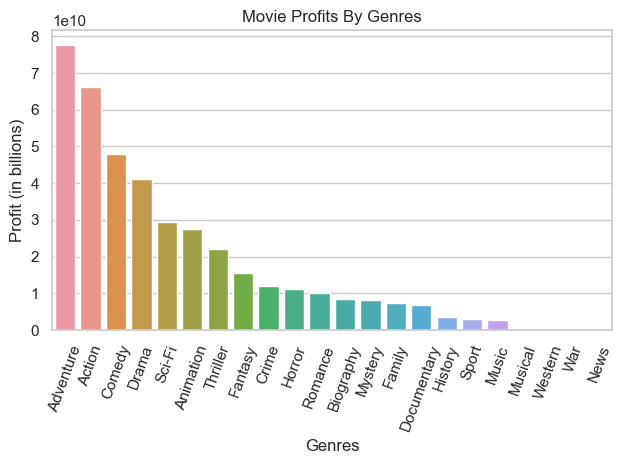

In [66]:
# Split the "Genres" column into multiple rows, so each genre has its own row
df_genres = movies_data.assign(Genre=movies_data['Genres'].str.split(', ')).explode('Genre')

# Group by genre and sum the profits
profits_by_genre = df_genres.groupby('Genre')['Profit'].sum()

# Sort genres descending by greatest profits
profits_by_genre = profits_by_genre.reset_index().sort_values(by='Profit', ascending=False)

# Plot profits_by_genre
ax = sns.barplot(data=profits_by_genre, x='Genre', y='Profit')

# Set axes labels, title, and rotate x ticks
ax.set(xlabel='Genres', ylabel='Profit (in billions)', title='Movie Profits By Genres')
plt.xticks(rotation=70)

plt.tight_layout();

In [67]:
profits_by_genre

,Genre,Profit
1,Adventure,77715231698
0,Action,66105728038
4,Comedy,47928766189
7,Drama,41012259004
17,Sci-Fi,29478145977
2,Animation,27571511898
19,Thriller,22137327106
9,Fantasy,15530947606
5,Crime,11888414624
11,Horror,11091733522


### Movie Profits By *Director*

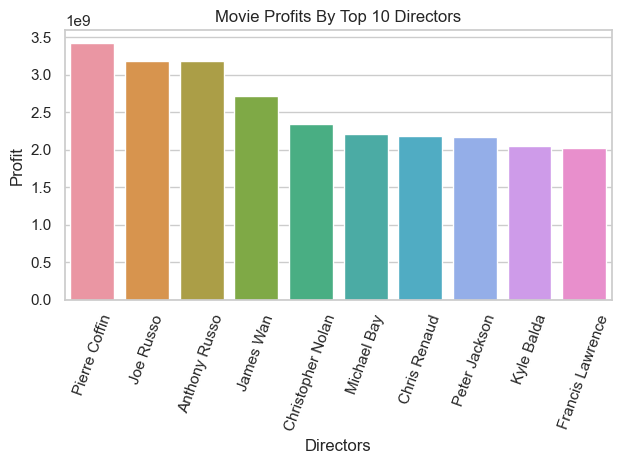

In [68]:
# Split the "Directors" column into multiple rows, so each director has their own row
df_directors = movies_data.assign(Director=movies_data['Directors'].str.split(', ')).explode('Director')

# Group by director and sum the profits
profits_by_director = df_directors.groupby('Director')['Profit'].sum()

# Create df of top 10 directors based on greatest profits
top_ten_directors = profits_by_director.reset_index().sort_values(by='Profit', ascending=False)[0:10]

# Plot profits_by_director
ax = sns.barplot(data=top_ten_directors, x='Director', y='Profit')

# Set axes labels, title, and rotate x ticks
ax.set(xlabel='Directors', ylabel='Profit', title='Movie Profits By Top 10 Directors')
plt.xticks(rotation=70)

plt.tight_layout();

In [59]:
top_ten_directors

,Director,Profit
942,Pierre Coffin,3419745331
543,Joe Russo,3182605502
78,Anthony Russo,3182605502
487,James Wan,2711988461
217,Christopher Nolan,2336180484
788,Michael Bay,2208722959
197,Chris Renaud,2185431942
928,Peter Jackson,2172948044
679,Kyle Balda,2046063923
371,Francis Lawrence,2021191543


In [55]:
# What genre of movies does Pierre Coffin make?
df_directors[df_directors['Director'] == 'Pierre Coffin']

,Title,Genres,Directors,Release_Month,Profit,Director
6,Despicable Me,"Animation, Comedy, Family","Chris Renaud, Pierre Coffin",Jul,474464573,Pierre Coffin
579,Despicable Me 2,"Adventure, Animation, Comedy","Chris Renaud, Pierre Coffin",Jul,899216835,Pierre Coffin
916,Minions,"Adventure, Animation, Comedy","Kyle Balda, Pierre Coffin",Jul,1086336173,Pierre Coffin
1300,Despicable Me 3,"Adventure, Animation, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon",Jun,959727750,Pierre Coffin


### Movie Profits By *Release Month*

In [ ]:
## DETERMINE WHICH LINE PLOT TO USE

/var/folders/pn/v9tvzf9s5ms7zcp53821ct0m0000gn/T/ipykernel_91426/479893443.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profits_by_month = df_genres.groupby('Release_Month')['Profit'].sum()
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


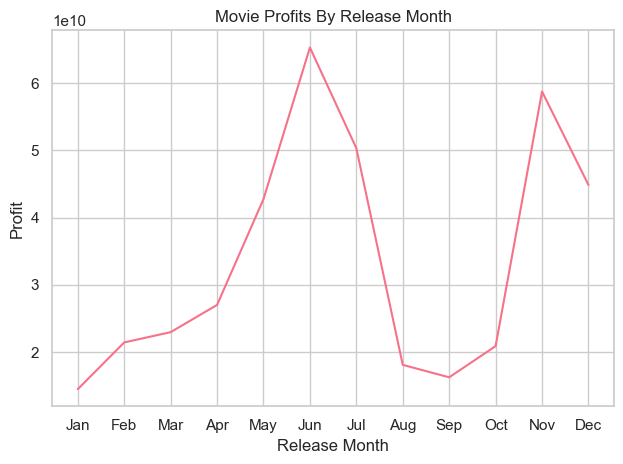

In [62]:
# Group by release month and sum the profits
profits_by_month = df_genres.groupby('Release_Month')['Profit'].sum()

# Reset index
profits_by_month = profits_by_month.reset_index()

ax = sns.lineplot(data=profits_by_month, x='Release_Month', y='Profit')

# Set axes labels, title, and rotate x ticks
ax.set(xlabel='Release Month', ylabel='Profit', title='Movie Profits By Release Month');

plt.tight_layout();

/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


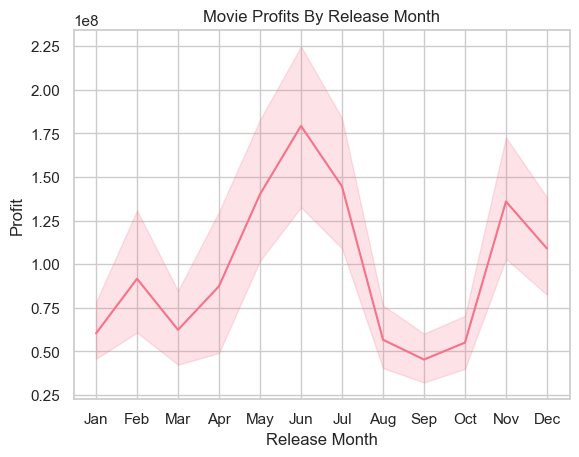

In [50]:
ax = sns.lineplot(data=movies_data, x='Release_Month', y='Profit')
ax.set(xlabel='Release Month', ylabel='Profit', title='Movie Profits By Release Month');

In [69]:
profits_by_month

,Release_Month,Profit
0,Jan,14517992814
1,Feb,21460961327
2,Mar,22988173985
3,Apr,27031359821
4,May,42748598982
5,Jun,65275799762
6,Jul,50311193119
7,Aug,18127236885
8,Sep,16278359201
9,Oct,20916802656


# Conclusions

## Limitations

There are various limitations in this analysis.

1. The datasets had to be greatly cut down. IMDB started with over 140,000 movies, but since there was not profit information for this data, our final dataset ended up being just under 1,600 movies to make sure each movie had profit, genre and director information.
2. The profit column used to determine success of a movie is based on worldwide gross minus budget. #TODO

## Recommendations

This analysis has led me to conclude the following three recommendations:

1. The **genre** of the first movie produced should be **adventure**. Adventure movies return the greatest profits at $77,715,231,698.
   
2. The **director** of the first movie produced should be **Pierre Coffin**. He has returned the greatest profits at $3,419,745,331.
   
3. The **release month** of the first movie produced should be **June**. This month returns the greatest profits at $65,275,799,762.

## Next Steps

Additional analysis could further exte
1. Analyze **budgets against profits** to determine a sweet spot for the budget for the first film. Consider costs to make film, marketing costs, and 
2. 